In [2]:
# need to run this twice due to bug in imported package

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

import numpy as np
import seaborn as sns
import sys
import json

import os

from scipy import stats

from matplotlib_venn import venn2

sys.path.append("../")
from protocols import Helpers
from protocols.BuildCatalogue import BuildCatalogue

import piezo

from protocols.Predict import piezo_predict, piezo_predict_cv

import warnings

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

## Data Import

In [3]:
mutations = pd.read_csv('./data/cryptic2_rev2/bdq_mutations.csv', index_col=0)
genomes = pd.read_pickle("./data/cryptic2_rev2/GENOMES.pkl.gz").reset_index()
phenotypes = pd.read_pickle("./data/cryptic2_rev2/DST_MEASUREMENTS.pkl.gz").reset_index()
growth = pd.read_pickle("./data/cryptic2//UKMYC_GROWTH.pkl.gz").reset_index()
growth = growth[growth.DRUG=='BDQ']


In [8]:
#number of samples in CRyPTIC
sha_pheno = pd.read_pickle('./data/shaheed/DST_MEASUREMENTS.pkl.gz').reset_index()
sha_ids = sha_pheno.UNIQUEID.unique().tolist()
pd.merge(genomes, phenotypes[(phenotypes.DRUG=='BDQ')&(~phenotypes.UNIQUEID.isin(sha_ids))&(~phenotypes.PHENOTYPE.isna())&(phenotypes.QUALITY=='HIGH')], how='inner', on='UNIQUEID').UNIQUEID.nunique()


10703

In [7]:
#number of samples from NICD
pd.merge(genomes, sha_pheno[(sha_pheno.PHENOTYPE=='R')], how='inner', on='UNIQUEID').UNIQUEID.nunique()


806

## Data prep for catalogue building

In [9]:
# filter plates (only) for high quality phenotypes
phenotypes = phenotypes[
    (phenotypes.DRUG == "BDQ")
    & (
        ((phenotypes.METHOD_3 == "MGIT960") & (phenotypes.SOURCE == "NICD"))
        | ((phenotypes.QUALITY.isin(["HIGH"])))
    )
    & (~phenotypes.PHENOTYPE.isna())
]

phenotypes = (
    phenotypes.groupby("UNIQUEID")
    .apply(Helpers.FilterMultiplePhenos)
    .reset_index(drop=True)
)

# create Gene@Mutation
mutations["GENE_MUT"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
mutations["IS_SYNONYMOUS"] = mutations["GENE_MUT"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)

# Filter out synonymous mutations
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()

# Merge genomes and phenotypes tables
samples = pd.merge(genomes, phenotypes, on="UNIQUEID", how="inner")[
    ["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]
]

piezo_wildcards = {
    "Rv0678@*=": {"pred": "S", "evid": {}},
    "Rv0678@-*_indel": {"pred": "U", "evid": {}},
    "Rv0678@*_indel": {"pred": "U", "evid": {}},
    "Rv0678@-*?": {"pred": "U", "evid": {}},
    "Rv0678@*?": {"pred": "U", "evid": {}},
    "Rv0678@del_0.0": {"pred": "U", "evid": {}},
    "pepQ@*=": {"pred": "S", "evid": {}},
    "pepQ@-*_indel": {"pred": "U", "evid": {}},
    "pepQ@*_indel": {"pred": "U", "evid": {}},
    "pepQ@-*?": {"pred": "U", "evid": {}},
    "pepQ@*?": {"pred": "U", "evid": {}},
    "pepQ@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@*=": {"pred": "S", "evid": {}},
    "mmpS5@-*_indel": {"pred": "U", "evid": {}},
    "mmpS5@*_indel": {"pred": "U", "evid": {}},
    "mmpS5@-*?": {"pred": "U", "evid": {}},
    "mmpS5@*?": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpL5@*=": {"pred": "S", "evid": {}},
    "mmpL5@-*_indel": {"pred": "U", "evid": {}},
    "mmpL5@*_indel": {"pred": "U", "evid": {}},
    "mmpL5@-*?": {"pred": "U", "evid": {}},
    "mmpL5@*?": {"pred": "U", "evid": {}},
    "mmpL5@del_0.0": {"pred": "U", "evid": {}},
    "atpE@*=": {"pred": "S", "evid": {}},
    "atpE@-*_indel": {"pred": "U", "evid": {}},
    "atpE@*_indel": {"pred": "U", "evid": {}},
    "atpE@-*?": {"pred": "U", "evid": {}},
    "atpE@*?": {"pred": "U", "evid": {}},
    "atpE@del_0.0": {"pred": "U", "evid": {}},
}

We use high quality phenotypes due to low signal in CRypTIC 1, and therefore good chance of FP. So get rid of them. 

## Basic Numbers (at FRS 0.75)

### Non-wt samples - used to build catalogues 

In [10]:
all_cat = pd.merge(cat_mutations, phenotypes, on=["UNIQUEID"], how="inner")
Helpers.CombinedDataTable((all_cat[all_cat.FRS>=0.75]))

All               Minor alleles             All                \
          R      S  Total             R   S Total     R      S  Total   
Total   860  10898  11758            62  57   119  2151  21467  23618   
mmpL5   859  10896  11755             5  36    41  1572  20640  22212   
Rv0678  533    364    897            57  19    76   554    374    928   
pepQ     13    150    163             1   2     3    13    361    374   
mmpS5     1     56     57             0   0     0     1     59     60   
atpE     11     14     25             3   1     4    11     33     44   

       Minor alleles            
                   R   S Total  
Total             67  66   133  
mmpL5              6  44    50  
Rv0678            57  19    76  
pepQ               1   2     3  
mmpS5              0   0     0  
atpE               3   1     4

All 11260 non-wt samples contain an mmpL5 non-synonymous variant - this corresponds to 21481 mutations in mmpL5 in total.

### All samples - used to test catalogues (include wt and synonymous)

In [11]:
all = pd.merge(samples, mutations, on=["UNIQUEID"], how="left")
all['GENE'].fillna('None', inplace=True)
Helpers.CombinedDataTable((all[all.FRS>=0.75]))

All               Minor alleles             All                \
          R      S  Total             R   S Total     R      S  Total   
Total   860  10901  11761            62  61   123  2198  22380  24578   
mmpL5   859  10898  11757             5  39    44  1616  21205  22821   
Rv0678  533    385    918            57  19    76   555    398    953   
pepQ     13    212    225             1   3     4    13    635    648   
mmpS5     2     78     80             0   1     1     2     82     84   
atpE     12     25     37             3   1     4    12     60     72   

       Minor alleles            
                   R   S Total  
Total             67  72   139  
mmpL5              6  48    54  
Rv0678            57  19    76  
pepQ               1   3     4  
mmpS5              0   1     1  
atpE               3   1     4

## Test the WHO catalogue on our dataset

The WHO have achieved a maximum sensitivity of 59.6% - but this was constructed and validated on a dataset with very limited BDQ resistance. Therefore, let's test on our dataset, which contains new NICD samples... 

Text(54.08333333333333, 0.5, 'True')

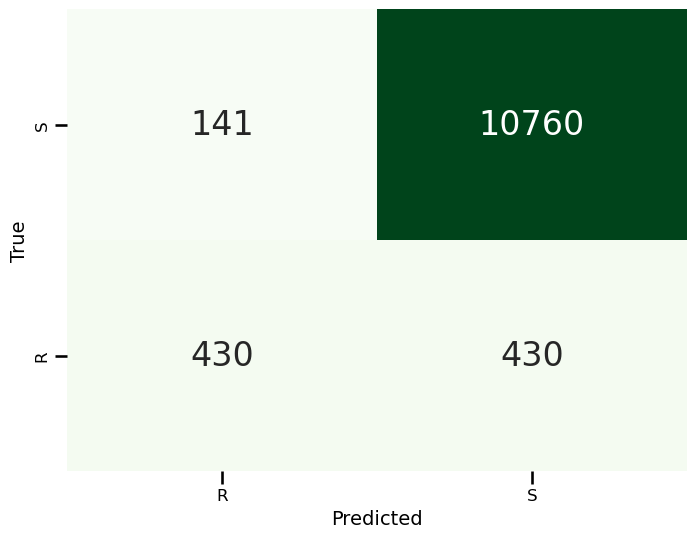

In [12]:
cm, _cov, _who_sens_75, _who_spec_75, _FN_ids = piezo_predict(all[all.FRS>=0.75], "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

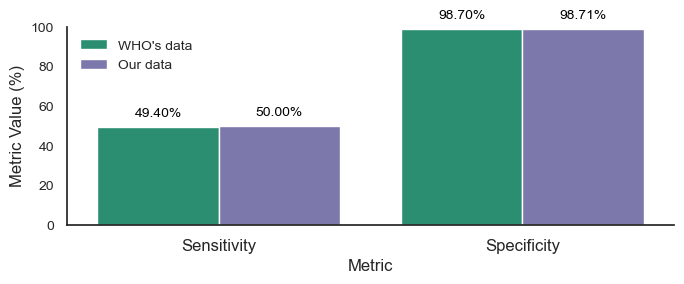

In [32]:
performance = {
    "WHO's data":{"Sensitivity": 49.4, "Specificity": 98.7},
    'Our data':{"Sensitivity": _who_sens_75*100, "Specificity": _who_spec_75*100}
}

Helpers.compare_metrics(performance)

We try at FRS 0.75 first.... then we notice they differentiate between testing at 0.75 and 0.25. So now lets try 0.25....

Text(57.08333333333333, 0.5, 'True')

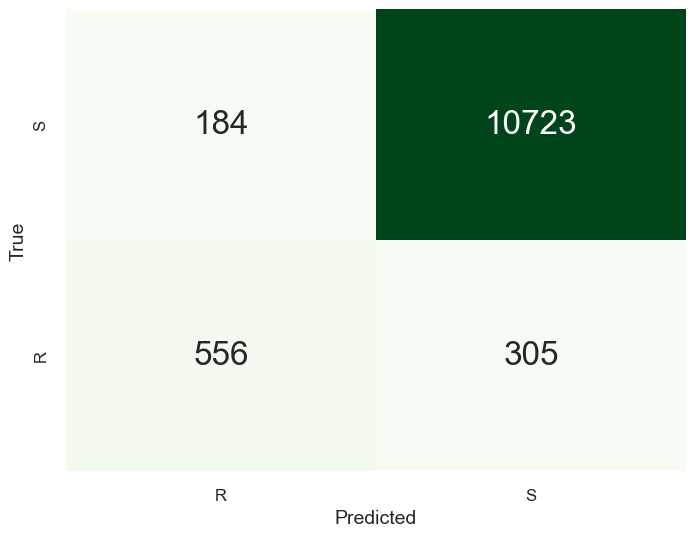

In [33]:
cm, _cov, _who_sens_25, _who_spec_25, _FN_ids = piezo_predict(all[all.FRS>=0.25], "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

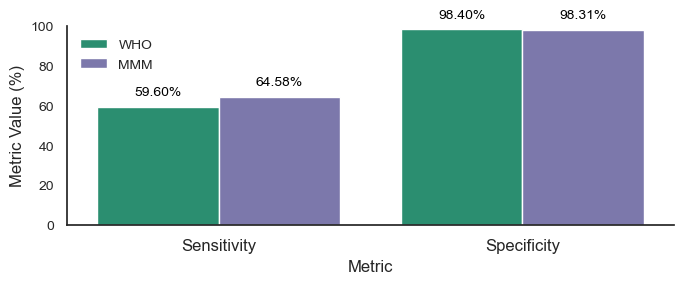

In [34]:
performance = {
    'WHO':{"Sensitivity": 59.6, "Specificity": 98.4},
    'MMM':{"Sensitivity": _who_sens_25*100, "Specificity": _who_spec_25*100}
}

Helpers.compare_metrics(performance)

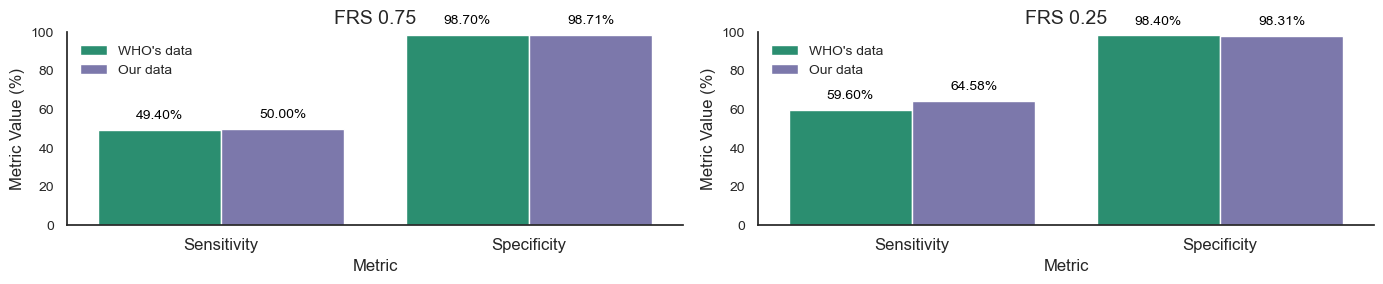

In [35]:
# combine into one axis


performance = {
    0.75: {
        "WHO's data": {"Sensitivity": 49.4, "Specificity": 98.7},
        "Our data": {"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
    },
    0.25: {
        "WHO's data": {"Sensitivity": 59.6, "Specificity": 98.4},
        "Our data": {"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
    },
}

Helpers.compare_metrics_2charts(performance)

We don't do too well, although validating at FRS 0.25 does give a big boost

The WHO's approach uses conservative statistical thresholds and a complex, stringent confidence grading system. This can perhaps be justified if one has tonnes of data and a good R population, but that's not relaly the case here. We suspect they're missing variants, which drops their senitivity.

## Build and test our catalogue at FRS 0.75

We have accordingly developed our own algorithm, which is more permissive in its approach, and we construct our catalogues on a dataset injected with novel, highly resistant samples. Owing to mmpL5@I948V being present in every sample, and literature evidence (fowler + whov2) that it is phylogenetic, we assume its neutral. Mirroring the WHO We can construct our catalogue at FRS 0.75 and test at FRS 0.75.

Text(57.08333333333333, 0.5, 'True')

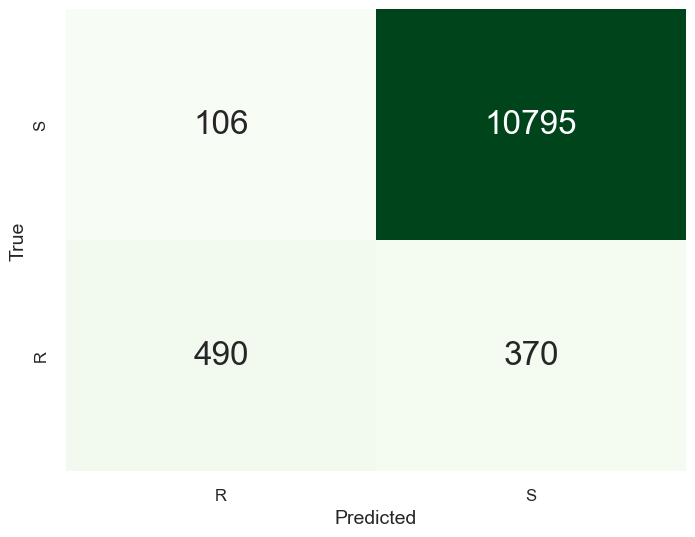

In [36]:
#build at FRS 0.75
catalogue_75 = BuildCatalogue(samples, cat_mutations, 0.75, hardcoded={'mmpL5@I948V': 'S'}).return_piezo(
        "NC_000962.3", f"BDQ-FRS-75-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv", index=False)
#test at FRS 0.75
cm, _cov, _sens_75, _spec_75, _FN_ids = piezo_predict(
        all[all.FRS>=0.75],
        f"./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv",
        "BDQ",
        Print=False,
        U_to_S=True
    )

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

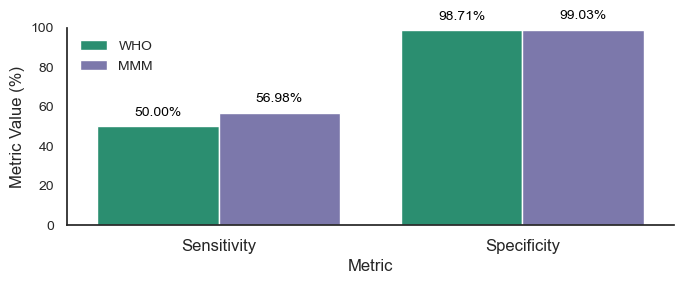

In [37]:
performance = {
    'WHO':{"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
    'MMM':{"Sensitivity": _sens_75*100, "Specificity": _spec_75*100}
}

Helpers.compare_metrics(performance)

We do a bit better than the WHO at a test FRS 0.75. However, they do get an increase at test FRS 0.25, so lets try that.

Text(57.08333333333333, 0.5, 'True')

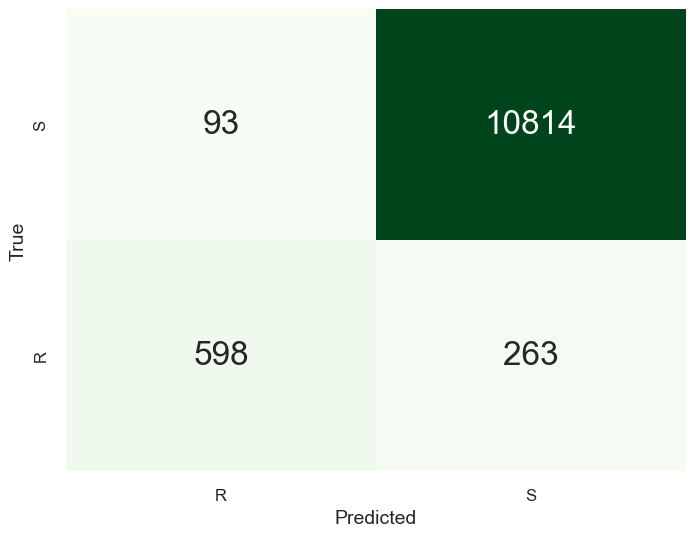

In [38]:
#test at FRS 0.25
cm, _cov, _sens_25, _spec_25, _FN_ids = piezo_predict(
        all[all.FRS>=0.25],
        f"./catalogues/manuscript_2/var_frs/catalogue_FRS_25.csv",
        "BDQ",
        Print=False,
        U_to_S=True
    )

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

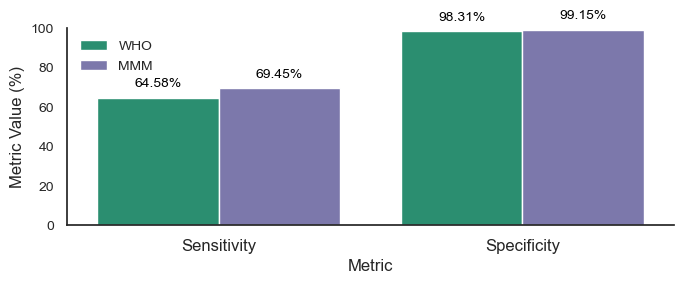

In [39]:
performance = {
    'WHO':{"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
    'MMM':{"Sensitivity": _sens_25*100, "Specificity": _spec_25*100}
}

Helpers.compare_metrics(performance)

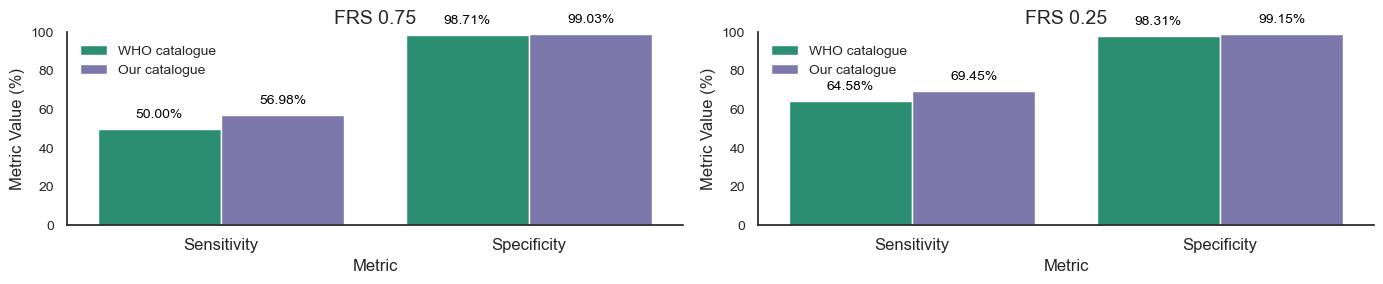

In [40]:
# combine into one axis


performance = {
    0.75: {
        "WHO catalogue": {"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
        "Our catalogue": {"Sensitivity": _sens_75 * 100, "Specificity": _spec_75 * 100},
    },
    0.25: {
        "WHO catalogue": {"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
        "Our catalogue": {"Sensitivity": _sens_25 * 100, "Specificity": _spec_25 * 100},
    },
}

Helpers.compare_metrics_2charts(performance)

## Why do we do better? Discrepancy analysis

mmpL5 and mmpS5 are missing from the parsed WHO catalogue - is this becuae their either uncertain significance or interim? its becuase they all come at at S.

In [44]:
who = pd.read_csv('./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv')
#U's are basically the same as not catalogued, so can get rid of. 'F's are for HET calls, which have non-HET equivalents, so get rid of
who_bdq = who[(who.DRUG=='BDQ')&(who.PREDICTION.isin(['R', 'S']))]
who_bdq['PREDICTION_VALUES'] = 'RS'


mmm_75 = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv')
mmm_75 = mmm_75[mmm_75.PREDICTION.isin(['R', 'S'])]
#mmpL5 and mmpS5 all come out as susceptible in the WHO catalogues, therefore not much point comparing (and the parsed catalogues don't contain them)
#becuase mmpL5 and mmpS5 are S in both catalogues, we don't need to compare them as they'll come out as S anyway if present/not present (U --> S)
mmm_75 = mmm_75[~mmm_75.index.isin([i for i in mmm_75.index if mmm_75['MUTATION'][i].split('@')[0] in ['mmpL5', 'mmpS5']])]

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_87394/2089491562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  who_bdq['PREDICTION_VALUES'] = 'RS'


In [45]:
# could use Piezo to determine if mmm mutations exist within the who rules - can natively assess whether our mutations 'match' WHO rules
# e.g) does Rv0678@V1? match Rv0678@V1Q?

# we can use the who catalogue as a catalogue
# we can use the mmm catalogue as the sample df and see what predictions are made for each row. If 'R' or 'S', then there was a match. If 'U' then there was no match (as U's have all been filtered out)
# we also need to add the mmpL5 and mmpS5 genes to the 'catalogue' - we can call their synonymous mutations S as a wildcard as a placeholder (as there shouldnt be any synonymous mutations in the mmm catalogue)
who_comp = who_bdq.append(
    pd.Series(
        [
            "NC_000962.3",
            "WHO-UCN-GTB-PCI-2023.5",
            2.0,
            "GARC1",
            "RS",
            "BDQ",
            "mmpL5@*=",
            "S",
            {},
            {},
            {},
        ],
        index=who_bdq.columns,
    ),
    ignore_index=True,
)
who_comp = who_comp.append(
    pd.Series(
        [
            "NC_000962.3",
            "WHO-UCN-GTB-PCI-2023.5",
            2.0,
            "GARC1",
            "RS",
            "BDQ",
            "mmpS5@*=",
            "S",
            {},
            {},
            {},
        ],
        index=who_comp.columns,
    ),
    ignore_index=True,
)

who_comp.to_csv("./catalogues/temp/who_bdq_adapted.csv")

catalogue = piezo.ResistanceCatalogue("./catalogues/temp/who_bdq_adapted.csv")

matched = {"shared": [], "not_shared": []}
for var in mmm_75.MUTATION:
    try:
        if catalogue.predict(var)["BDQ"] in ["R", "S"]:
            # matched (and either R or S = actually catalogued)
            matched["shared"].append(var)
        else:
            #'U'
            matched["not_shared"].append(var)

    except ValueError:
        matched["not_shared"].append(var)

matched['shared']

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_87394/3040232311.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  who_comp = who_bdq.append(
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_87394/3040232311.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  who_comp = who_comp.append(


['Rv0678@R38!',
 'Rv0678@M146T',
 'Rv0678@492_ins_g',
 'Rv0678@C46R',
 'Rv0678@372_del_g',
 'pepQ@928_ins_g',
 'Rv0678@R156!',
 'Rv0678@30_del_g',
 'Rv0678@418_ins_g',
 'Rv0678@c-11a',
 'Rv0678@142_ins_t',
 'Rv0678@L117R',
 'Rv0678@234_ins_t',
 'Rv0678@212_del_c',
 'Rv0678@345_del_g',
 'Rv0678@492_ins_ga',
 'Rv0678@419_del_gggatctgtt',
 'pepQ@V1M',
 'Rv0678@193_del_g',
 'Rv0678@192_ins_g',
 'Rv0678@141_ins_c',
 'Rv0678@465_ins_c',
 'Rv0678@L32S',
 'Rv0678@Q115!',
 'Rv0678@138_ins_g',
 'Rv0678@136_ins_g',
 'atpE@A63P',
 'pepQ@150_ins_c',
 'Rv0678@Y92!',
 'Rv0678@471_del_cagc',
 'Rv0678@140_ins_tc',
 'Rv0678@292_del_a',
 'Rv0678@I67S',
 'Rv0678@423_ins_c',
 'Rv0678@199_ins_tc',
 'Rv0678@148_ins_g',
 'Rv0678@289_del_c',
 'Rv0678@287_del_g',
 'Rv0678@150_ins_c',
 'Rv0678@167_del_tggcgacggcgctggcggccagcagcggggggatcagcaccaatgcccggatgctgatccaatttgggttcattgagcggctcgcggtcgccggggatcggcgcacctattt',
 'Rv0678@132_ins_gt',
 'Rv0678@441_ins_t',
 'Rv0678@G121R',
 'Rv0678@Q76!',
 'Rv0678@265_ins_t',
 '

In [46]:
#ok, now determine left and right tails of this (ie not shared)
#to determine which mutations in the WHO catalogue are not present in mmm catalogue, need to remove aggregates (as these could consitute any number of different mutations)
wildcard_chars = {'*', '?', '='}

who_only = who_bdq[~who_bdq['MUTATION'].isin(matched['shared'])]['MUTATION'].unique()
who_only = [i for i in who_only if not any(c in i for c in wildcard_chars)]
who_only

['Rv0678@del_1.0',
 'Rv0678@R132!',
 'Rv0678@E138!',
 'Rv0678@Y145!',
 'Rv0678@E147!',
 'atpE@D28G',
 'atpE@D28A',
 'atpE@D28V',
 'atpE@E61D',
 'pepQ@del_1.0',
 'pepQ@Q5!']

In [47]:
mmm_only = mmm_75[~mmm_75['MUTATION'].isin(matched['shared'])]['MUTATION'].unique()
mmm_only = [i for i in mmm_only if not any(c in i for c in wildcard_chars)]
mmm_only

['Rv0678@R50Q',
 'pepQ@A42G',
 'Rv0678@I80M',
 'pepQ@A370V',
 'pepQ@P69L',
 'Rv0678@S158R',
 'Rv0678@Q22R',
 'Rv0678@I108T',
 'pepQ@A263V',
 'pepQ@D20G',
 'pepQ@A153G',
 'Rv0678@I108V',
 'Rv0678@-21_ins_ttc',
 'Rv0678@D5G',
 'Rv0678@L74M',
 'atpE@-44_ins_c',
 'pepQ@D26A',
 'pepQ@I24T',
 'Rv0678@402_del_acggctgcggga',
 'Rv0678@V85A',
 'atpE@A45V',
 'pepQ@S66P',
 'Rv0678@M139I',
 'pepQ@S66L',
 'pepQ@V298I',
 'pepQ@G85C',
 'pepQ@N118D',
 'pepQ@V102I',
 'Rv0678@G103S',
 'pepQ@D209E',
 'pepQ@V343A',
 'pepQ@A305V',
 'Rv0678@M17V',
 'pepQ@V101L',
 'Rv0678@c-25t',
 'pepQ@G197R',
 'pepQ@V45L',
 'pepQ@S130L',
 'pepQ@V328F',
 'Rv0678@F27S',
 'pepQ@F46L',
 'Rv0678@L40V',
 'pepQ@G228E',
 'Rv0678@L74V',
 'Rv0678@R72W',
 'pepQ@A137S',
 'Rv0678@g-29a',
 'pepQ@L107R',
 'atpE@F74L',
 'Rv0678@N98D',
 'pepQ@G91D',
 'pepQ@V324M',
 'pepQ@A313S',
 'Rv0678@c-3a',
 'pepQ@L71V',
 'Rv0678@V20A',
 'Rv0678@G25C',
 'Rv0678@S68I',
 'Rv0678@A59V',
 'Rv0678@D15A',
 'pepQ@V238M',
 'Rv0678@E55D',
 'Rv0678@G24S',
 'Rv067

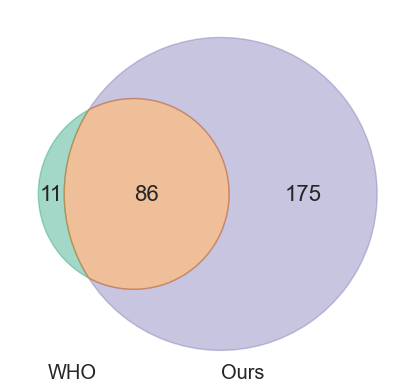

In [72]:
v = venn2(subsets=(len(who_only), len(mmm_only), len(matched['shared'])), set_labels=['WHO', 'Ours'])
v.get_patch_by_id('10').set_color('#1b9e77')  # Color for WHO only
v.get_patch_by_id('01').set_color('#7570b3')  # Color for MMM only
v.get_patch_by_id('11').set_color('#d95f02')  # Color for intersection

if v.set_labels[0]:  # Check if the 'WHO' label exists
    label = v.set_labels[0]
    x, y = label.get_position()
    label.set_position((x - 0.13, y-0.215)) 

for text in v.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(16)  # Adjust fontsize here


plt.show()

In [53]:
# ok, the who catalogue contains 11 mutations ours doesn't and we contain 175 the WHO doesn't.
# but there is an overlap of 86 Rv0678, pepQ, or atpE mutations - lets investigate these and see if there are any phenotype discrepencies

pheno_matched = {'shared':[], 'R_mmm':[], 'S_mmm':[]}

catalogue = piezo.ResistanceCatalogue("./catalogues/temp/who_bdq_adapted.csv")
for mut in mmm_75.index:
    mutation = mmm_75['MUTATION'][mut]
    mmm_predict = mmm_75['PREDICTION'][mut]
    try:
        who_predict = catalogue.predict(mutation)['BDQ']
        if who_predict != 'U':
            if who_predict == mmm_predict:
                # matched (and either R or S = actually catalogued)
                pheno_matched['shared'].append(mutation)
            elif who_predict=='R' and mmm_predict=='S':
                pheno_matched['S_mmm'].append(mutation)
            elif who_predict=='S' and mmm_predict=='R':
                pheno_matched['R_mmm'].append(mutation)

    except ValueError:
            continue

pheno_matched


{'shared': ['Rv0678@c-11a',
  'pepQ@V1M',
  'Rv0678@193_del_g',
  'Rv0678@192_ins_g',
  'Rv0678@141_ins_c',
  'Rv0678@465_ins_c',
  'Rv0678@L32S',
  'Rv0678@Q115!',
  'Rv0678@138_ins_g',
  'Rv0678@136_ins_g',
  'atpE@A63P',
  'pepQ@150_ins_c',
  'Rv0678@Y92!',
  'Rv0678@471_del_cagc',
  'Rv0678@140_ins_tc',
  'Rv0678@292_del_a',
  'Rv0678@I67S',
  'Rv0678@423_ins_c',
  'Rv0678@199_ins_tc',
  'Rv0678@148_ins_g',
  'Rv0678@289_del_c',
  'Rv0678@287_del_g',
  'Rv0678@150_ins_c',
  'Rv0678@167_del_tggcgacggcgctggcggccagcagcggggggatcagcaccaatgcccggatgctgatccaatttgggttcattgagcggctcgcggtcgccggggatcggcgcacctattt',
  'Rv0678@132_ins_gt',
  'Rv0678@441_ins_t',
  'Rv0678@G121R',
  'Rv0678@Q76!',
  'Rv0678@265_ins_t',
  'atpE@I66M',
  'Rv0678@422_ins_tc',
  'Rv0678@N70D',
  'Rv0678@383_del_c',
  'pepQ@817_ins_g',
  'Rv0678@E113!',
  'Rv0678@433_del_tatatgg',
  'Rv0678@W42!',
  'Rv0678@137_ins_tg',
  'pepQ@230_ins_g',
  'Rv0678@419_del_g',
  'Rv0678@491_ins_cg',
  'Rv0678@A36V',
  'Rv0678@128_del_t

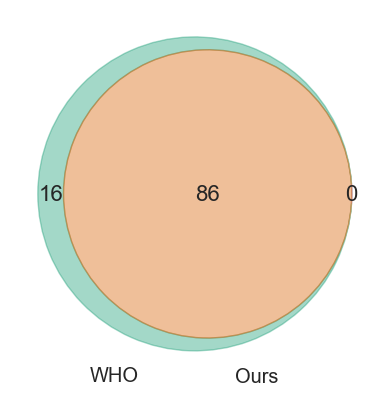

In [67]:
v = venn2(subsets=(len(pheno_matched['S_mmm']), len(pheno_matched['R_mmm']), len(matched['shared'])), set_labels=['WHO', 'Ours'])
v.get_patch_by_id('10').set_color('#1b9e77')  # Color for WHO only
v.get_patch_by_id('01').set_color('#7570b3')  # Color for MMM only
v.get_patch_by_id('11').set_color('#d95f02')  # Color for intersection

if v.set_labels[0]:  # Check if the 'WHO' label exists
    label = v.set_labels[0]
    x, y = label.get_position()
    label.set_position((x-0.2 , y)) 
    
    label = v.set_labels[1]
    x, y = label.get_position()
    label.set_position((x+0.1 , y-0.05)) 

for text in v.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(16)  # Adjust fontsize here


plt.show()

Compare numbers of variants in each gene catalogued = coarse grain.

Compare actual variants (dylan - who, who - dylan) = fine grain

Try and find some meaning behind the major variant or gene discrepencies

Is the reason we get different performance when testing at FRS 0.25 the same as the WHO? Is it because we are being more liberal? Or is it becuase of our data?

## Build catalogues as a function of FRS

Up until now, we have followed the WHO's strategy of building at FRS 0.75 and testing at 0.75 and 0.25. Surely it makes more sense to also build at FRS 0.25 - if minor alleles are clinically significant and contribute to resistance, then those that exclusively exist at lower FRS should be included in the catalogue surely? If they are relevant, then they should all be captured. We should build at FRS 0.25, however one of the benefifts of a deterministic alogorithmic approach is we can easily construct our catalogues as a function of FRS and compare performance across the entire FRS range. To allow max number of samples in for validation, lets drop out test FRS to 0.1

In [9]:
sens, spec, cov, FNs = [], [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    #Build and save catalogue across FRS range
    BuildCatalogue(samples, cat_mutations, i, hardcoded={'mmpL5@I948V':'S'}).return_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/var_frs/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue at FRS 0.1
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all[all.FRS>=0.1],
        f"./catalogues/manuscript_2/var_frs/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=False, U_to_S=True
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FNs.append(_FN_ids)
    FRS.append(i)
data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov, "FNs":FNs}
)

Helpers.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False) 

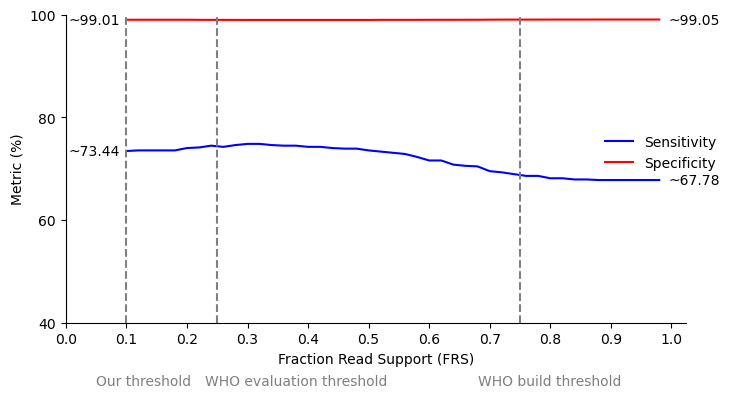

In [46]:
FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False) 

We get a sensitivity drop at lower FRS - . Why? Could either be due to an increase in incorrect classifications (from R to S/U), or from an increase in the number of catalogued mutations with incorrect classifications (increase S/U). A clean way to determine this is a venn diagram of a catalogue built at FRS 0.25 and on at 0.75 (just to be consistent).

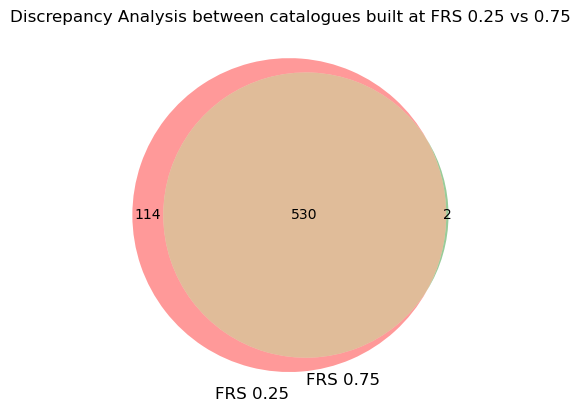

In [34]:
catalogue25 = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_25.csv')
catalogue75 = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv')

shared = pd.merge(catalogue25, catalogue75, on='MUTATION', how='inner')['MUTATION'].unique()
unique25 = catalogue25[~catalogue25['MUTATION'].isin(shared)]['MUTATION'].unique()
unique75 = catalogue75[~catalogue75['MUTATION'].isin(shared)]['MUTATION'].unique()

venn2(subsets=(len(unique25), len(unique75), len(shared)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

So at FRS 0.25 we have gained 109 mutations (and lost 2). I suspect some of these are creating our false negatives. May be easier to examine which classifications changed first - within shared bracket look at discrepencies for S and U.

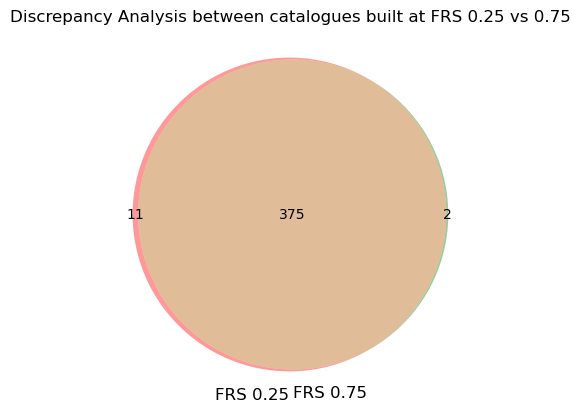

In [36]:
catalogue25_shared =  catalogue25[catalogue25.MUTATION.isin(shared)]
catalogue75_shared =  catalogue75[catalogue75.MUTATION.isin(shared)]

catalogue25_shared_S =  catalogue25_shared[catalogue25_shared.PREDICTION=='S']
catalogue75_shared_S =  catalogue75_shared[catalogue75_shared.PREDICTION=='S']

shared_S = pd.merge(catalogue25_shared_S, catalogue75_shared_S, on='MUTATION', how='inner')['MUTATION'].unique()
unique25_S = catalogue25_shared_S[~catalogue25_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()
unique75_S = catalogue75_shared_S[~catalogue75_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()

venn2(subsets=(len(unique25_S), len(unique75_S), len(shared_S)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

So at FRS 0.25 11 mutations have changed classification from R/U to S - some of our false negatives will be in here. We only care about R to S, as the U's are effectively converted to S anyway during prediction (so they can't increase our number of false negatives). Therefore, how many of these are resistant at FRS 0.75?

In [37]:
catalogue75[catalogue75.MUTATION.isin(unique25_S)].PREDICTION.value_counts()

R    6
U    5
Name: PREDICTION, dtype: int64

6 mutations change their phenotype from R --> S when the phenotype drops. How many false negatives does this account for?

In [38]:
data['FRS'] = [str(round(i, 2)) for i in data.FRS]

FN25 = data[data.FRS=='0.26'].FNs.tolist()[0]

R_conv = catalogue75[(catalogue75.MUTATION.isin(unique25_S))&(catalogue75.PREDICTION=='R')].MUTATION.unique()

all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN25))&(all.GENE_MUT.isin(R_conv))].UNIQUEID.nunique()

54

Okay so 6 R --> S classificaitons account for 54 false negatives from FRS 0.75 --> 0.25. This could explain all our false negatives, but lets just make sure.

We could also be gaining U classifications (which come out as S) from R. Let's do a quick run through.

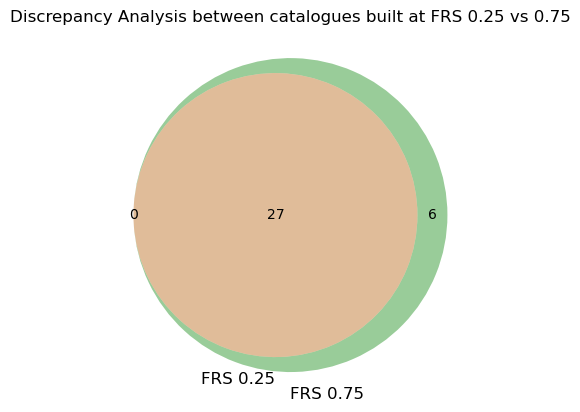

In [39]:
catalogue25_shared_U =  catalogue25_shared[catalogue25_shared.PREDICTION=='U']
catalogue75_shared_U =  catalogue75_shared[catalogue75_shared.PREDICTION=='U']

shared_U = pd.merge(catalogue25_shared_U, catalogue75_shared_U, on='MUTATION', how='inner')['MUTATION'].unique()
unique25_U = catalogue25_shared_U[~catalogue25_shared_U['MUTATION'].isin(shared_U)]['MUTATION'].unique()
unique75_U = catalogue75_shared_U[~catalogue75_shared_U['MUTATION'].isin(shared_U)]['MUTATION'].unique()

venn2(subsets=(len(unique25_U), len(unique75_U), len(shared_U)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

We don't get any R --> U, so this doesn't explain any of our false negatives. And in fact, dropping FRS decreases the number of U classifications we have (as one would hope).

How many new false negatives are still unexplained?

In [40]:
len(FN25) - len(data[data.FRS=='0.76'].FNs.tolist()[0]) - 48

-36

Still like R --> S reclassifications explain 100% of our false negatives. Let's finally examine our new mutations - how many of the incoming mutations are classified as S, and do these exist in any of our false negatives?

In [41]:
catalogue25[catalogue25.MUTATION.isin(unique25)].PREDICTION.value_counts()

S    76
R    38
Name: PREDICTION, dtype: int64

In [42]:
S_new = catalogue25[(catalogue25.MUTATION.isin(unique25))&(catalogue25.PREDICTION=='S')].MUTATION.unique()

all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN25))&(all.GENE_MUT.isin(S_new))].UNIQUEID.nunique()

18

Ok, no false negatives are attributable to the 71 incoming mutations classified as susceptible when dropping the FRS. All new false negatives are due to 6 mutations re-classified from R --> S.

Therefore - although we get an increase in the number of mutation catalogued and that we can classify (ie not U), which results in a higher specificity, erroroneous classifications are introduced as the FRS is dropped.

## All mmpL5 variants are classified as S

Another observation is that all mmpL5 variants are catalouged as S, suggesting mmpL5 does not contribute to resistance. Therefore, we should be able to build a catalogue without the gene with no negative impact on performance:

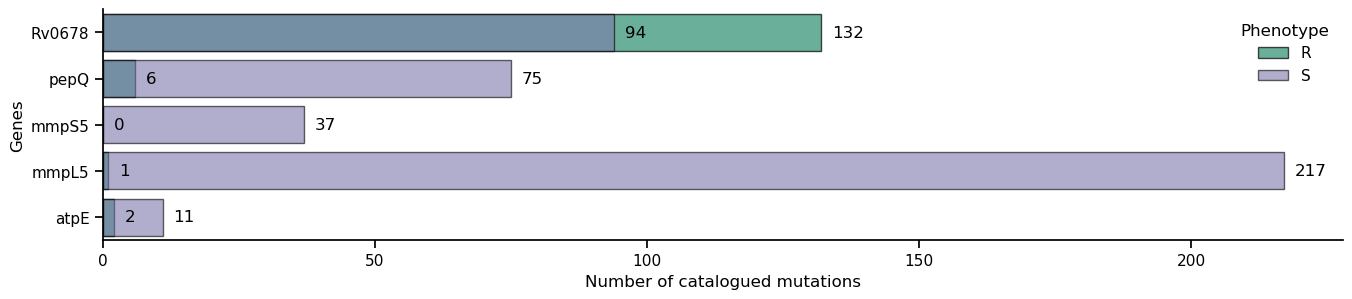

In [42]:


catalogue_01_df = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_10.csv')
catalogue_01_df = catalogue_01_df[~catalogue_01_df['MUTATION'].str.contains('\*', regex=True)]
Helpers.plot_catalogue_counts_h(all, catalogue_01_df)


In [14]:
catalogue_01_df[catalogue_01_df.PREDICTION=='S']

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@I948V,S,{},{},{}
1,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@T794I,S,{},"{""solo_R"": 61, ""solo_S"": 1651, ""background_R"":...",{}
2,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,Rv0678@R50Q,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 56,...",{}
3,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@A147T,S,{},"{""solo_R"": 0, ""solo_S"": 15, ""background_R"": 56...",{}
4,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@Q707K,S,{},"{""solo_R"": 0, ""solo_S"": 2, ""background_R"": 56,...",{}
...,...,...,...,...,...,...,...,...,...,...,...
578,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,Rv0678@*=,S,{},{},{}
584,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,pepQ@*=,S,{},{},{}
591,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpS5@*=,S,{},{},{}
596,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@*=,S,{},{},{}


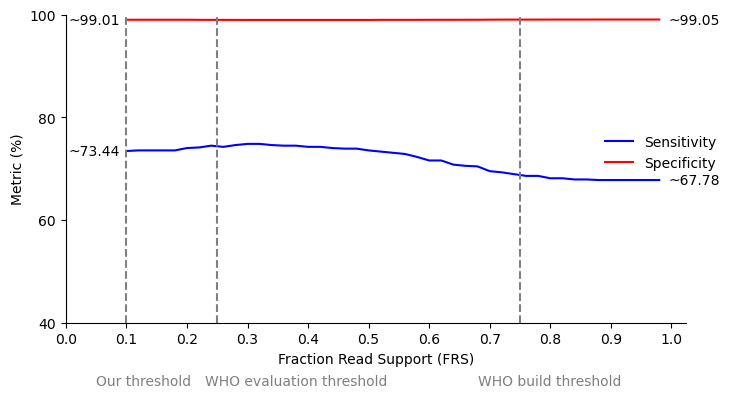

In [43]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue building
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]

sens, spec, cov, FNs = [], [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    #Build and save catalogue
    BuildCatalogue(samples, mutations_no_mmpL5, i).return_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all_WT_mmpL5,
        f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=False, U_to_S=True
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FNs.append(_FN_ids)
    FRS.append(i)



data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov, "FNs":FNs}
)
Helpers.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False) 


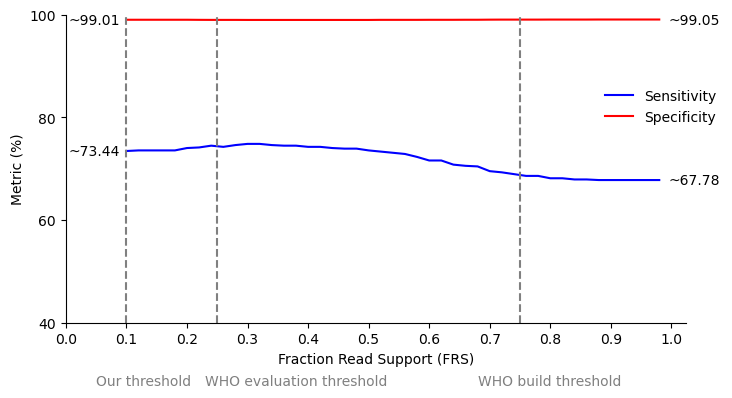

In [50]:
FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False) 


Okay, now we get a an increase in sensitivity as FRS drops - and not switch like either, but rather gradual - suggests being more permissive and allowing in Rv0678 minor alleles improves performance - reinforces idea that minor allelels are clinically significant. Let's do a quick discrepency analysis to see why performance increases. Its either because of additional classifications or reclassifications from U/S to R.

In [25]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue building
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all_WT_mmpL5,
        f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{24}.csv",
        "BDQ",
        Print=False, U_to_S=True
    )

In [27]:
_sens

0.7448036951501155

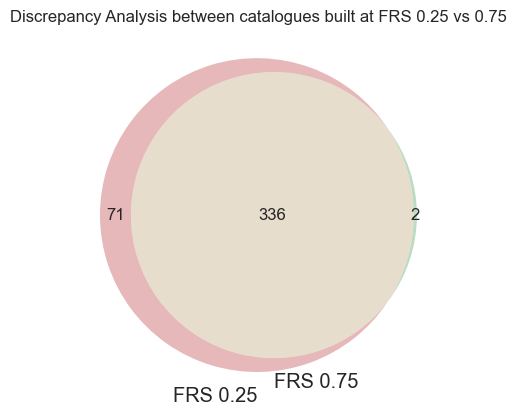

In [67]:
catalogue25 = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_24.csv')
catalogue75 = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_76.csv')

shared = pd.merge(catalogue25, catalogue75, on='MUTATION', how='inner')['MUTATION'].unique()
unique25 = catalogue25[~catalogue25['MUTATION'].isin(shared)]['MUTATION'].unique()
unique75 = catalogue75[~catalogue75['MUTATION'].isin(shared)]['MUTATION'].unique()

venn2(subsets=(len(unique25), len(unique75), len(shared)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

How many of the new mutations are classified as R?

In [68]:
catalogue25[catalogue25.MUTATION.isin(unique25)].PREDICTION.value_counts()

R    39
S    32
Name: PREDICTION, dtype: int64

How many false negatives does this increase in sensitivity correspond to?

In [69]:
#data['FRS'] = [str(round(i, 2)) for i in data.FRS]

FN75 = data[data.FRS=='0.76'].FNs.tolist()[0]

len(FN75) - len(data[data.FRS=='0.26'].FNs.tolist()[0])

IndexError: list index out of range

How many false negatives are resolved by these new, resistant mutations?

In [ ]:
new_R = catalogue25[(catalogue25.MUTATION.isin(unique25))&(catalogue25.PREDICTION=='R')]

all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN75))&(all.GENE_MUT.isin(unique25))].UNIQUEID.nunique()

46

So 46/51 false negatives that are resolved can be explained by an influx of newly catalogued mutations when the FRS is dropped. There are therefore 5 false negatives that result from a mutation reclassification of U/S to R - lets investigate how many reclassifications of U cause this.

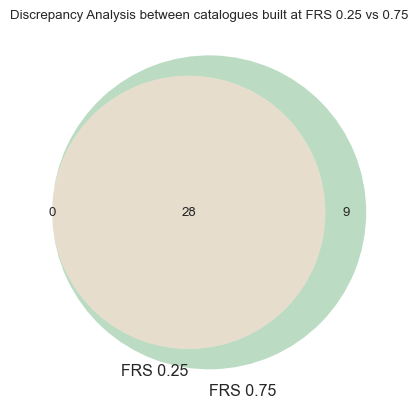

In [ ]:
catalogue25_shared =  catalogue25[catalogue25.MUTATION.isin(shared)]
catalogue75_shared =  catalogue75[catalogue75.MUTATION.isin(shared)]

catalogue25_shared_S =  catalogue25_shared[catalogue25_shared.PREDICTION=='U']
catalogue75_shared_S =  catalogue75_shared[catalogue75_shared.PREDICTION=='U']

shared_S = pd.merge(catalogue25_shared_S, catalogue75_shared_S, on='MUTATION', how='inner')['MUTATION'].unique()
unique25_S = catalogue25_shared_S[~catalogue25_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()
unique75_S = catalogue75_shared_S[~catalogue75_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()

venn2(subsets=(len(unique25_S), len(unique75_S), len(shared_S)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

The are 9 mutations catalogued as 'U' at higher FRS whose classification changes when dropping the FRS. How many removed FN samples does this account for?

In [ ]:
FN_diff = list(set(FN75).symmetric_difference(set(FN25)))
all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN_diff))&(all.GENE_MUT.isin(unique75_S))].UNIQUEID.nunique()

6

And how many mutations are actually responsible for this?

In [ ]:
all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN_diff))&(all.GENE_MUT.isin(unique75_S))].GENE_MUT.nunique()

5

Therefore 6 false negative samples whose predicted phenotype change from S to R at lower FRS can be explained by 5 out of 9 mutations which are reclassified from U to R (some redundancy as some of these mutations co-existed with other resistant mutations anyway).

How many reclassifications of S mutations potentially contribute to the loss of FNs?

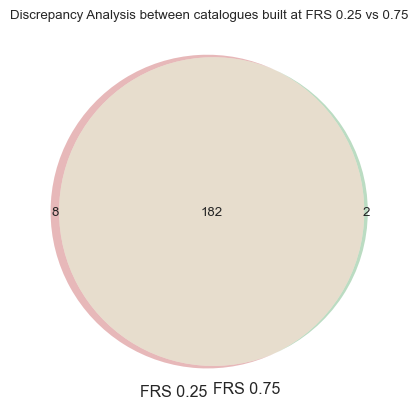

In [ ]:
catalogue25_shared_S =  catalogue25_shared[catalogue25_shared.PREDICTION=='S']
catalogue75_shared_S =  catalogue75_shared[catalogue75_shared.PREDICTION=='S']

shared_S = pd.merge(catalogue25_shared_S, catalogue75_shared_S, on='MUTATION', how='inner')['MUTATION'].unique()
unique25_S = catalogue25_shared_S[~catalogue25_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()
unique75_S = catalogue75_shared_S[~catalogue75_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()

venn2(subsets=(len(unique25_S), len(unique75_S), len(shared_S)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

How many FN (which are resolved at low FRS) contain these 2 S mutations at high FRS?

In [ ]:
FN_diff = list(set(FN75).symmetric_difference(set(FN25)))
all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN_diff))&(all.GENE_MUT.isin(unique75_S))].UNIQUEID.nunique()

4

Therefore, 46/51 FN samples at high FRS are correclty predicted R at low FRS due to an influx of new mutations (minor alleles) that are clinically significant and explain resistance. The rest can be explained by reclassiifcations: 2 S --> R + 5 R --> S

## Our optimal catalogue

This is all great, but we should present a catalogue that we can confident in and has attributes we consider more suitable for clinical use.

Attributes:
- No mmpL5 (perhaps include an epistatic link wildcard)
- FRS 0.1 to capture all variants, assuming minor alleles are clinically significant
- Keep U predictions seperate and use a new metric - coverage
- Piezo compatible - standardised format for easy, reproducible parsing
- Contigency table included in 'evidence column'
- All data published with a reproducible pipeline

Limitations:
- Validated on the training set - poor, but we don't have enough data to split

[[  636   204    26]
 [  109 10857    36]]
Catalogue coverage of isolates: 0.9947758678800135
Sensitivity: 0.7571428571428571
Specificity: 0.9900601860295458
0.7571428571428571


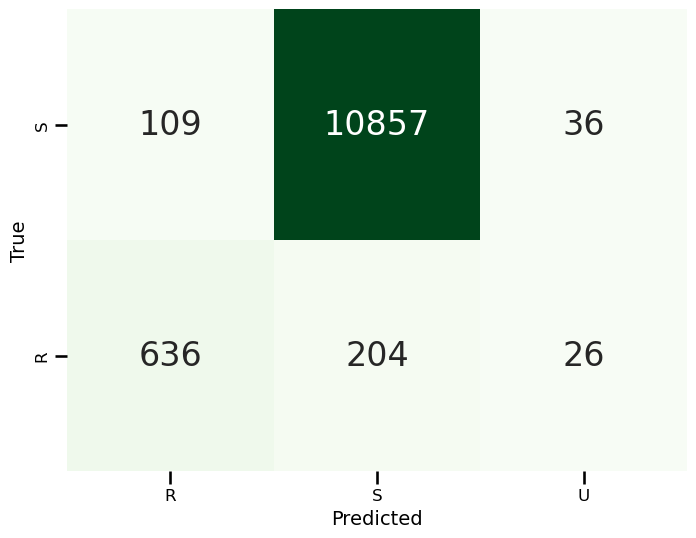

In [51]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue building
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]


#Build and save catalogue
BuildCatalogue(samples, mutations_no_mmpL5, 0.1).return_piezo(
        "NC_000962.3", f"BDQ-FRS-10-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv", index=False)
    #predict with catalogue
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all_WT_mmpL5,
        f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv",
        "BDQ",
        Print=True, U_to_S=False
    )

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

print (_sens, )

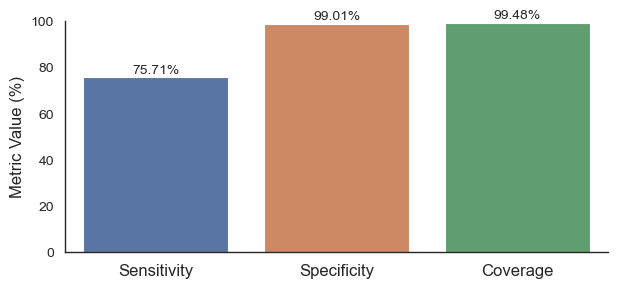

In [52]:
performance = {
    "Sensitivity": _sens*100, "Specificity": _spec*100, "Coverage": _cov*100
}

Helpers.plot_metrics(performance)

### CV on our optimal catalogue

[[ 118   45   30]
 [  28 2108   45]]
Catalogue coverage of isolates: 0.968407750631845
Sensitivity: 0.7239263803680982
Specificity: 0.9868913857677902
[[ 103   52   17]
 [  14 2155   33]]
Catalogue coverage of isolates: 0.97893850042123
Sensitivity: 0.6645161290322581
Specificity: 0.9935454126325496
[[ 122   34   28]
 [  28 2125   37]]
Catalogue coverage of isolates: 0.972620050547599
Sensitivity: 0.782051282051282
Specificity: 0.9869948908499768
[[ 105   49   22]
 [  14 2137   47]]
Catalogue coverage of isolates: 0.9709351305812974
Sensitivity: 0.6818181818181818
Specificity: 0.9934913993491399
[[ 109   44   16]
 [  24 2143   38]]
Catalogue coverage of isolates: 0.9772535804549284
Sensitivity: 0.7124183006535948
Specificity: 0.9889247808029534
isolate_cov (0.97363100252738, 0.003920834466123007)
specificity (0.9899695738804821, 0.0029868194179233387)
sensitivity (0.712946054784683, 0.04052352574422176)


Text(54.08333333333333, 0.5, 'True')

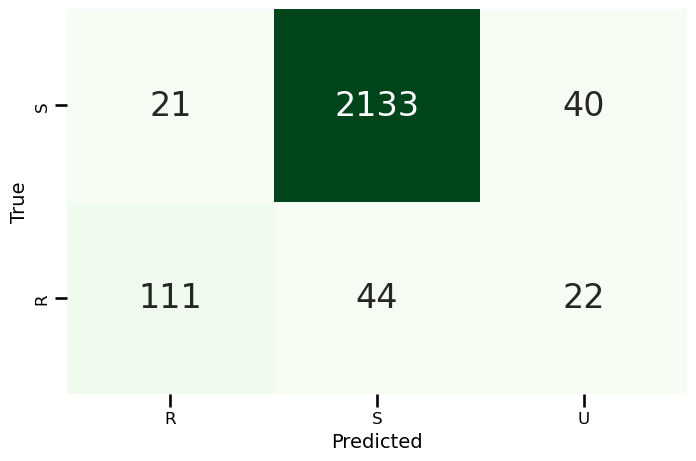

In [43]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue buildingq
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]

df_cm, labels, sens, spec, cov = piezo_predict_cv(all_WT_mmpL5, samples, mutations_no_mmpL5, 0.1, 5, 0.2, 7, "NC_000962.3", f"BDQ-FRS-10-2024.01", "1.1", "BDQ", piezo_wildcards, './catalogues/manuscript_2/cv/')
sns.set_context("talk")
plt.figure(figsize=(8, 5))
sns.heatmap(
    df_cm, annot=labels, cbar=False, cmap="Greens", fmt="", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)


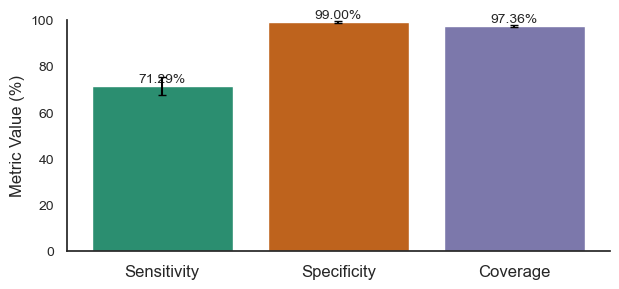

In [49]:
performance = {
    "Sensitivity": 100*sens[0],
    "Specificity": 100 * spec[0],
    "Coverage": 100 * cov[0],
}
stds = {
    "Sensitivity": 100 * sens[1],
    "Specificity": 100 * spec[1],
    "Coverage": 100 * cov[1],
}

def plot_metrics_std(performance, stds):
    df = pd.DataFrame(performance, index=[0])

    sns.set_style("white")

    plt.figure(figsize=(7, 3))

    # Define your specific colors for the bars here
    colors = ['#1b9e77', '#d95f02', '#7570b3' ]  # Example colors: blue, orange, green

    ax = sns.barplot(data=df, palette=colors)  # Use the palette argument to set the colors

    for k, v in stds.items():

        ax.errorbar(x=k, y=performance[k], yerr=v, color="black", zorder=10, capsize=3)


    ax.set_ylabel("Metric Value (%)", fontsize=12)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=10)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}%",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=10,
        )

    ax.set_ylim(0, 100)

    sns.despine()
    plt.show()

plot_metrics_std(performance, stds)

In [ ]:
v.get_patch_by_id('10').set_color('#1b9e77')  # Color for WHO only
v.get_patch_by_id('01').set_color('#7570b3')  # Color for MMM only
v.get_patch_by_id('11').set_color('#d95f02')

## Is there a correlation between FRS and MIC?

In [71]:
all["MIC_FLOAT"] = Helpers.mic_to_float(all["METHOD_MIC"].tolist())

catalogue_01_df = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_10.csv')

R_muts = catalogue_01_df[catalogue_01_df.PREDICTION == "R"].MUTATION.tolist()
# should only look at samples with a single R mutation (can have multipled S) that has been catalogued as R
ids, solo_Rs = all.UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df[(df.GENE_MUT.isin(R_muts))]) == 1:
        solo_Rs.append(i)

df = pd.DataFrame.from_dict(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

print(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

df["binned_FRS"] = [str(round(i, 1)) for i in df.FRS.tolist()]
df["binned_MIC"] = [str(i) for i in df.MIC]

df["MIC"] = [str(i) for i in df.MIC]

{'GENE_MUT': ['Rv0678@193_del_g', 'Rv0678@193_del_g', 'Rv0678@193_del_g', 'Rv0678@193_del_g', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@141_ins_c', 'Rv0678@465_ins_c', 'Rv0678@132_ins_gt', 'Rv0678@141_ins_c', 'Rv0678@L32S', 'Rv0678@Q115!', 'Rv0678@193_del_g', 'Rv0678@138_ins_g', 'Rv0678@138_ins_g', 'Rv0678@141_ins_c', 'Rv0678@R94W', 'Rv0678@138_ins_g', 'Rv0678@138_ins_g', 'pepQ@298_ins_c', 'Rv0678@141_ins_c', 'atpE@A63P', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@S2I', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@A84V', 'pepQ@150_ins_c', 'Rv0678@Y92!', 'Rv0678@471_del_cagc', 'Rv0678@140_ins_tc', 'Rv0678@141_ins_c', 'Rv0678@L40F', 'Rv0678@S63R', 'Rv0678@I67S', 'Rv0678@R94W', 'Rv0678@141_ins_c', 'Rv0678@L32S', 'Rv0678@423_ins_c', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@423_ins_c', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@V1E', 'Rv0678@376_del_ggcgac', 'Rv0678@141_ins_c', 'Rv0678@137_ins_tga', 'Rv0678@141_ins_c', 'Rv0678@423_ins_c', 'Rv0678@141_ins_c', 'Rv067

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_28272/1244953926.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_28272/1244953926.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(


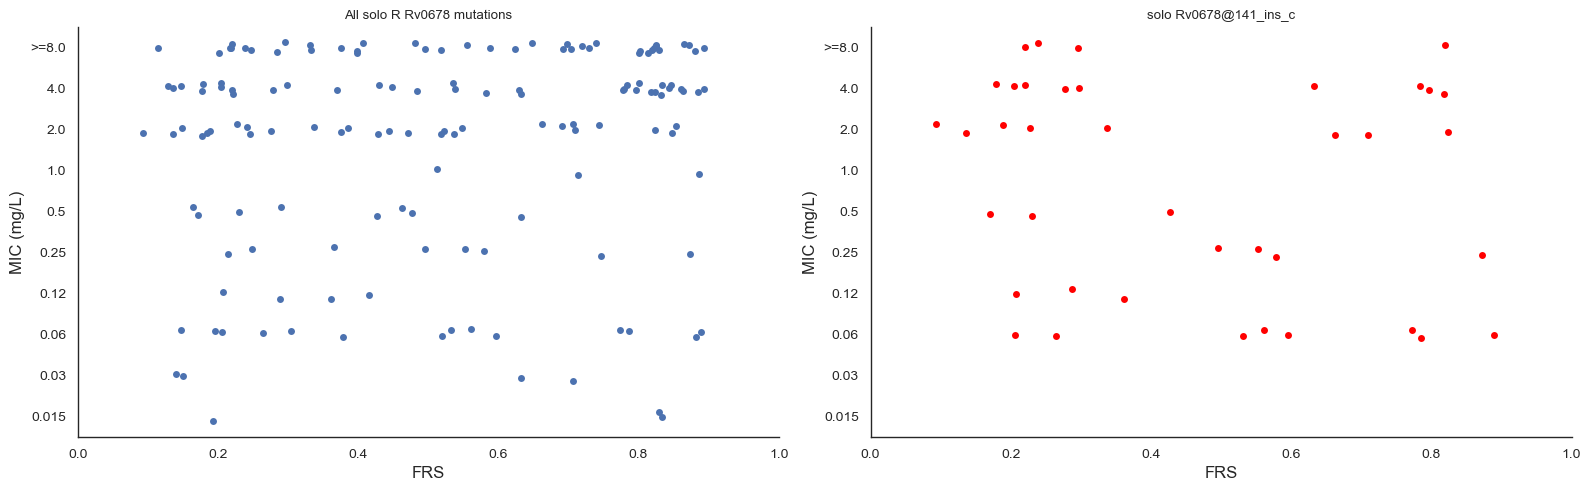

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.set_context("paper")

# axes[0].set_ylim(0, 3.5)
y_axis_order = [
    "0.015",
    "0.03",
    "0.06",
    "0.12",
    "0.25",
    "0.5",
    "1.0",
    "2.0",
    "4.0",
    "8.0",
]

sns.stripplot(
    x="FRS", y="MIC", data=df[df.FRS < 0.9], ax=axes[0], jitter=0.15, order=y_axis_order
)
axes[0].set_title("All solo R Rv0678 mutations")
axes[0].invert_yaxis()
axes[0].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)
axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("MIC (mg/L)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)


axes[0].set_xlim(0, 1)

sns.stripplot(
    x="FRS",
    y="MIC",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    jitter=0.15,
    color="red",
    order=y_axis_order,
)
axes[1].set_title("solo Rv0678@141_ins_c")
axes[1].invert_yaxis()
axes[1].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)

axes[1].set_xlim(0, 1)
# axes[1].set_ylim(0, 3.5)
axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("MIC (mg/L)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Adjust layout
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()

There is no correlation between FRS and MIC for Rv0678 resistant variants generally, as well as for the most variable (wrt FRS) mutations in Rv0678. This would suggest there is no effective fitness cost resulting from Rv0678 resistant mutations, as minor resistant populations can rapidly outcompete major WT populations. It would be interesting to analyse growth data from the plates, however this data is not available.

## Is there a correlation between FRS and Growth?

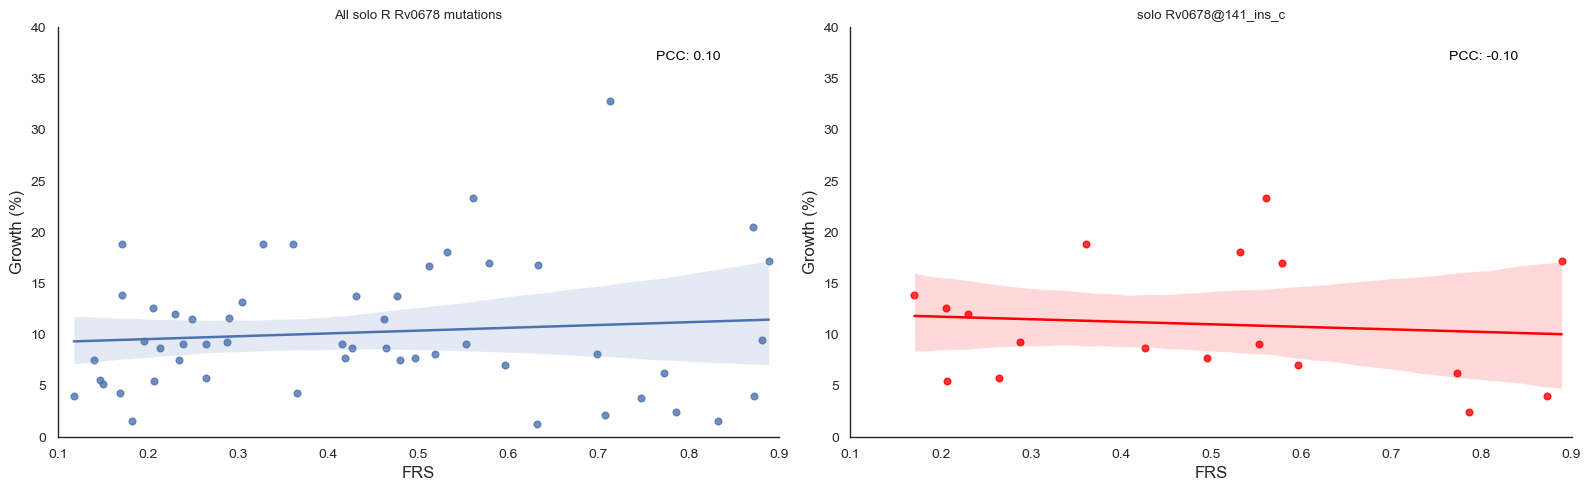

In [73]:
growth_dil = growth[(growth.DILUTION.isin([1, 2, 3])) & (growth.READINGDAY == 14)]
# subset growth data to dilutions of 1, 2, or 3 fold so there is drug present, and only look at growth at 14 days post incubation
growth_dil = growth_dil[["UNIQUEID", "GROWTH"]].groupby("UNIQUEID").mean()
# average growth across dilutions

df = pd.merge(growth_dil, cat_mutations[cat_mutations.GENE=='Rv0678'], how='inner', on='UNIQUEID')
#filter for samples with only a single resistant mutation (and however many S)
df = df[df.UNIQUEID.isin(solo_Rs)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.regplot(x="FRS", y="GROWTH", data=df[df.FRS < 0.9], ax=axes[0], ci=95)
axes[0].set_title("All solo R Rv0678 mutations")
axes[0].set_xlim(0.1, 0.9)
axes[0].set_ylim(0, 40)

axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("Growth (%)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)

# Calculate Pearson correlation coefficient
pcc_value = df[df.FRS < 0.9][["FRS", "GROWTH"]].corr().iloc[0, 1]

# Annotate the first subplot with the PCC value
axes[0].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)


sns.regplot(
    x="FRS",
    y="GROWTH",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    color="red",
    ci=95,
)
axes[1].set_title("solo Rv0678@141_ins_c")
axes[1].set_xlim(0.1, 0.9)  # Set x-axis range
axes[1].set_ylim(0, 40)

axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("Growth (%)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Calculate Pearson correlation coefficient
pcc_value = (
    df[(df.FRS < 0.9) & (df.GENE_MUT == "Rv0678@141_ins_c")][["FRS", "GROWTH"]]
    .corr()
    .iloc[0, 1]
)

# Annotate the first subplot with the PCC value
axes[1].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)
sns.despine()

# Adjust layout
plt.tight_layout()
